# Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

from LahmanDownloader import DownloadLahmanData

pd.set_option('display.max_columns', None)

# Overview
In this Notebook, we will be exploring if we can create a good model to see if we can try and determine the number of wins for each team. In the `./starting_project.ipynb` file, we saw that while the model we created wasn't that good at predicting games on a game to game basis, we were able to accuraately predict the number of games each franchise won. We will now try and turn our focus on that and see what kind of results we can get.

# Data

We will utilize the Lahman database for this

In [2]:
DownloadLahmanData().run()

In [3]:
TEAMS_PATH = './datasets/lahman/Teams.csv'

teams_df = pd.read_csv(TEAMS_PATH)
teams_df

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,NaN,NaN,N,NaN,401,1372,426,70,37,3,60.0,19.0,73.0,16.0,NaN,NaN,303,109,3.55,22,1,3,828,367,2,42,23,243,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,NaN,NaN,N,NaN,302,1196,323,52,21,10,60.0,22.0,69.0,21.0,NaN,NaN,241,77,2.76,25,0,1,753,308,6,28,22,229,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,NaN,NaN,N,NaN,249,1186,328,35,40,7,26.0,25.0,18.0,8.0,NaN,NaN,341,116,4.11,23,0,0,762,346,13,53,34,234,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,NaN,NaN,N,NaN,137,746,178,19,8,2,33.0,9.0,16.0,4.0,NaN,NaN,243,97,5.17,19,1,0,507,261,5,21,17,163,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,NaN,NaN,N,NaN,302,1404,403,43,21,1,33.0,15.0,46.0,15.0,NaN,NaN,313,121,3.72,32,1,0,879,373,7,42,22,235,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,2020,NL,SLN,STL,C,3,58,27.0,30,28,N,Y,N,N,240,1752,410,73,7,51,205.0,477.0,18.0,10.0,33.0,16.0,229,205,3.90,2,0,13,1419,376,69,204,464,33,46,0.983,St. Louis Cardinals,Busch Stadium III,0.0,97,96,STL,SLN,SLN
2951,2020,AL,TBA,TBD,E,1,60,29.0,40,20,Y,N,Y,N,289,1975,470,105,12,80,243.0,608.0,48.0,9.0,28.0,14.0,229,209,3.56,0,0,23,1583,475,70,168,552,33,52,0.985,Tampa Bay Rays,Tropicana Field,0.0,96,95,TBR,TBA,TBA
2952,2020,AL,TEX,TEX,W,5,60,30.0,22,38,N,N,N,N,224,1936,420,80,9,62,167.0,548.0,49.0,14.0,24.0,18.0,312,288,5.02,2,1,10,1550,479,81,236,489,40,40,0.981,Texas Rangers,Globe Life Field,0.0,102,102,TEX,TEX,TEX
2953,2020,AL,TOR,TOR,E,3,60,26.0,32,28,N,Y,N,N,302,2023,516,104,4,88,203.0,508.0,33.0,6.0,12.0,14.0,312,268,4.60,0,0,17,1574,517,81,250,519,38,47,0.982,Toronto Blue Jays,Sahlen Field,0.0,100,99,TOR,TOR,TOR


In [4]:
FRANCHISE_PATH = './datasets/lahman/TeamsFranchises.csv'

franchises_df = pd.read_csv(FRANCHISE_PATH)
franchises_df

,franchID,franchName,active,NAassoc
0,ALT,Altoona Mountain City,N,NaN
1,ANA,Los Angeles Angels of Anaheim,Y,NaN
2,ARI,Arizona Diamondbacks,Y,NaN
3,ATH,Philadelphia Athletics,N,PNA
4,ATL,Atlanta Braves,Y,BNA
...,...,...,...,...
115,WNL,Washington Nationals,N,NaN
116,WNT,Washington Nationals,NaN,NaN
117,WOR,Worcester Ruby Legs,N,NaN
118,WSN,Washington Nationals,Y,NaN


Let's get the teams that played at least 145 games and are still active. There are 30 teams that are currently active

In [5]:
active_teams_df = pd.merge(teams_df,
                           franchises_df,
                           on=['franchID'])

active_teams_df = active_teams_df.loc[(active_teams_df['G'] > 145) &
                                      (active_teams_df['active'] == 'Y') &
                                      (active_teams_df['yearID'] > 1900)]

active_teams_df

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,franchName,active,NAassoc
78,1904,NL,BSN,ATL,NaN,7,155,79.0,55,98,NaN,NaN,N,NaN,491,5135,1217,153,50,24,316.0,550.0,143.0,NaN,42.0,NaN,749,514,3.43,136,13,0,4045,1405,25,500,544,353,91,0.945,Boston Beaneaters,South End Grounds III,140694.0,96,101,BSN,BSN,BSN,Atlanta Braves,Y,BNA
79,1905,NL,BSN,ATL,NaN,7,156,76.0,51,103,NaN,NaN,N,N,468,5190,1217,148,52,17,302.0,561.0,132.0,NaN,54.0,NaN,733,541,3.52,139,14,0,4149,1390,36,433,533,325,89,0.951,Boston Beaneaters,South End Grounds III,150003.0,98,103,BSN,BSN,BSN,Atlanta Braves,Y,BNA
80,1906,NL,BSN,ATL,NaN,8,152,76.0,49,102,NaN,NaN,N,N,408,4925,1115,136,43,16,356.0,681.0,93.0,NaN,52.0,NaN,649,465,3.14,137,10,0,4003,1291,24,436,562,337,102,0.947,Boston Beaneaters,South End Grounds III,143280.0,97,102,BSN,BSN,BSN,Atlanta Braves,Y,BNA
81,1907,NL,BSN,ATL,NaN,7,152,74.0,58,90,NaN,NaN,N,N,502,5020,1222,142,61,22,413.0,508.0,120.0,NaN,57.0,NaN,652,496,3.33,121,9,2,4016,1324,28,458,426,249,128,0.961,Boston Doves,South End Grounds III,203221.0,100,103,BSN,BSN,BSN,Atlanta Braves,Y,BNA
82,1908,NL,BSN,ATL,NaN,6,156,78.0,63,91,NaN,NaN,N,N,537,5131,1228,137,43,17,414.0,489.0,134.0,NaN,54.0,NaN,622,436,2.79,92,14,1,4214,1262,29,423,416,253,90,0.962,Boston Doves,South End Grounds III,253750.0,98,102,BSN,BSN,BSN,Atlanta Braves,Y,BNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2015,AL,TBA,TBD,E,4,162,84.0,80,82,N,N,N,N,644,5485,1383,278,32,167,436.0,1310.0,87.0,45.0,84.0,47.0,642,604,3.74,1,12,60,4360,1314,175,477,1355,95,118,0.984,Tampa Bay Rays,Tropicana Field,1287054.0,100,102,TBR,TBA,TBA,Tampa Bay Rays,Y,NaN
2950,2016,AL,TBA,TBD,E,5,162,81.0,68,94,N,N,N,N,672,5481,1333,288,32,216,449.0,1482.0,60.0,37.0,69.0,28.0,713,665,4.20,1,8,42,4279,1395,210,491,1357,94,129,0.984,Tampa Bay Rays,Tropicana Field,1286163.0,93,94,TBR,TBA,TBA,Tampa Bay Rays,Y,NaN
2951,2017,AL,TBA,TBD,E,3,162,81.0,80,82,N,N,N,N,694,5478,1340,226,32,228,545.0,1538.0,88.0,34.0,55.0,48.0,704,638,3.97,0,9,53,4335,1324,193,503,1352,100,129,0.983,Tampa Bay Rays,Tropicana Field,1253619.0,94,94,TBR,TBA,TBA,Tampa Bay Rays,Y,NaN
2952,2018,AL,TBA,TBD,E,3,162,81.0,90,72,N,N,N,N,716,5475,1415,274,43,150,540.0,1388.0,128.0,51.0,101.0,50.0,646,602,3.74,0,14,52,4345,1236,164,501,1421,85,136,0.986,Tampa Bay Rays,Tropicana Field,1154973.0,97,97,TBR,TBA,TBA,Tampa Bay Rays,Y,NaN


Get the columns that have null values

In [6]:
active_teams_df.isnull().sum()

yearID               0
lgID                 0
teamID               0
franchID             0
divID             1038
Rank                 0
G                    0
Ghome                0
W                    0
L                    0
DivWin            1038
WCWin             1648
LgWin                0
WSWin               16
R                    0
AB                   0
H                    0
2B                   0
3B                   0
HR                   0
BB                   0
SO                  16
SB                   0
CS                 400
HBP                950
SF                1062
RA                   0
ER                   0
ERA                  0
CG                   0
SHO                  0
SV                   0
IPouts               0
HA                   0
HRA                  0
BBA                  0
SOA                  0
E                    0
DP                   0
FP                   0
name                 0
park                 0
attendance           0
BPF        

We will drop the columns that have a lot of null values and fill the null values of columns that don't have many missing values. We will also drop any columns that aren't necessary

In [7]:
active_teams_df.drop(columns=['lgID',
                              'franchID',
                              'divID',
                              'Rank',
                              'Ghome',
                              'L',
                              'DivWin',
                              'WCWin',
                              'LgWin',
                              'WSWin',
                              'SF',
                              'name',
                              'park',
                              'attendance',
                              'BPF',
                              'PPF',
                              'teamIDBR',
                              'teamIDlahman45',
                              'teamIDretro',
                              'franchID',
                              'franchName',
                              'active',
                              'NAassoc'],
                     inplace=True)

# Don't need strikeouts and we don't need hit-by-pitch
active_teams_df.drop(columns=['CS', 'HBP'],
                     inplace=True)

# Fill null values for strikeouts and double plays
active_teams_df['SO'] = active_teams_df['SO'].fillna(active_teams_df['SO'].median())
active_teams_df['DP'] = active_teams_df['DP'].fillna(active_teams_df['DP'].median())

active_teams_df

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP
78,1904,BSN,155,55,491,5135,1217,153,50,24,316.0,550.0,143.0,749,514,3.43,136,13,0,4045,1405,25,500,544,353,91,0.945
79,1905,BSN,156,51,468,5190,1217,148,52,17,302.0,561.0,132.0,733,541,3.52,139,14,0,4149,1390,36,433,533,325,89,0.951
80,1906,BSN,152,49,408,4925,1115,136,43,16,356.0,681.0,93.0,649,465,3.14,137,10,0,4003,1291,24,436,562,337,102,0.947
81,1907,BSN,152,58,502,5020,1222,142,61,22,413.0,508.0,120.0,652,496,3.33,121,9,2,4016,1324,28,458,426,249,128,0.961
82,1908,BSN,156,63,537,5131,1228,137,43,17,414.0,489.0,134.0,622,436,2.79,92,14,1,4214,1262,29,423,416,253,90,0.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2015,TBA,162,80,644,5485,1383,278,32,167,436.0,1310.0,87.0,642,604,3.74,1,12,60,4360,1314,175,477,1355,95,118,0.984
2950,2016,TBA,162,68,672,5481,1333,288,32,216,449.0,1482.0,60.0,713,665,4.20,1,8,42,4279,1395,210,491,1357,94,129,0.984
2951,2017,TBA,162,80,694,5478,1340,226,32,228,545.0,1538.0,88.0,704,638,3.97,0,9,53,4335,1324,193,503,1352,100,129,0.983
2952,2018,TBA,162,90,716,5475,1415,274,43,150,540.0,1388.0,128.0,646,602,3.74,0,14,52,4345,1236,164,501,1421,85,136,0.986


In [8]:
active_teams_df.isnull().sum()

yearID    0
teamID    0
G         0
W         0
R         0
AB        0
H         0
2B        0
3B        0
HR        0
BB        0
SO        0
SB        0
RA        0
ER        0
ERA       0
CG        0
SHO       0
SV        0
IPouts    0
HA        0
HRA       0
BBA       0
SOA       0
E         0
DP        0
FP        0
dtype: int64

Since statistics vary from year to year, we should figure out the number of runs on average each team let's up per game per year and the number of runs they allow per game per year.

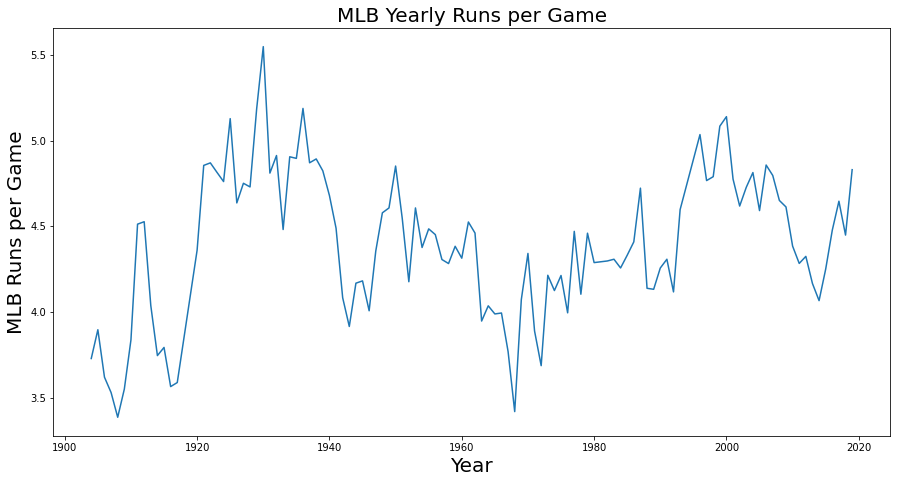

In [9]:
runs_per_game_per_year = {}

for year in set(active_teams_df['yearID']):
    games = active_teams_df.loc[active_teams_df['yearID'] == year]['G'].sum()
    runs = active_teams_df.loc[active_teams_df['yearID'] == year]['R'].sum()
    runs_per_game_per_year[year] = runs/games

x, y = zip(*sorted(runs_per_game_per_year.items()))

plt.figure(figsize=(15, 7.5))
plt.plot(x, y)
plt.title('MLB Yearly Runs per Game', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('MLB Runs per Game', fontsize=20)

plt.show()
plt.close()

In [10]:
for year, rpg in runs_per_game_per_year.items():
    active_teams_df['rpgpy'] = rpg

active_teams_df

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,rpgpy
78,1904,BSN,155,55,491,5135,1217,153,50,24,316.0,550.0,143.0,749,514,3.43,136,13,0,4045,1405,25,500,544,353,91,0.945,4.830589
79,1905,BSN,156,51,468,5190,1217,148,52,17,302.0,561.0,132.0,733,541,3.52,139,14,0,4149,1390,36,433,533,325,89,0.951,4.830589
80,1906,BSN,152,49,408,4925,1115,136,43,16,356.0,681.0,93.0,649,465,3.14,137,10,0,4003,1291,24,436,562,337,102,0.947,4.830589
81,1907,BSN,152,58,502,5020,1222,142,61,22,413.0,508.0,120.0,652,496,3.33,121,9,2,4016,1324,28,458,426,249,128,0.961,4.830589
82,1908,BSN,156,63,537,5131,1228,137,43,17,414.0,489.0,134.0,622,436,2.79,92,14,1,4214,1262,29,423,416,253,90,0.962,4.830589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2015,TBA,162,80,644,5485,1383,278,32,167,436.0,1310.0,87.0,642,604,3.74,1,12,60,4360,1314,175,477,1355,95,118,0.984,4.830589
2950,2016,TBA,162,68,672,5481,1333,288,32,216,449.0,1482.0,60.0,713,665,4.20,1,8,42,4279,1395,210,491,1357,94,129,0.984,4.830589
2951,2017,TBA,162,80,694,5478,1340,226,32,228,545.0,1538.0,88.0,704,638,3.97,0,9,53,4335,1324,193,503,1352,100,129,0.983,4.830589
2952,2018,TBA,162,90,716,5475,1415,274,43,150,540.0,1388.0,128.0,646,602,3.74,0,14,52,4345,1236,164,501,1421,85,136,0.986,4.830589


In [11]:
active_teams_df['rpg'] = active_teams_df['R'] / active_teams_df['G']
active_teams_df['rapg'] = active_teams_df['RA'] / active_teams_df['G']
active_teams_df['rpg/rapg'] = active_teams_df['rpg']/active_teams_df['rapg']
active_teams_df['rpg/rpgpy/rapg'] = active_teams_df['rpg'] / active_teams_df['rpgpy'] / active_teams_df['rapg']

active_teams_df

,yearID,teamID,G,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,rpgpy,rpg,rapg,rpg/rapg,rpg/rpgpy/rapg
78,1904,BSN,155,55,491,5135,1217,153,50,24,316.0,550.0,143.0,749,514,3.43,136,13,0,4045,1405,25,500,544,353,91,0.945,4.830589,3.167742,4.832258,0.655541,0.135706
79,1905,BSN,156,51,468,5190,1217,148,52,17,302.0,561.0,132.0,733,541,3.52,139,14,0,4149,1390,36,433,533,325,89,0.951,4.830589,3.000000,4.698718,0.638472,0.132173
80,1906,BSN,152,49,408,4925,1115,136,43,16,356.0,681.0,93.0,649,465,3.14,137,10,0,4003,1291,24,436,562,337,102,0.947,4.830589,2.684211,4.269737,0.628659,0.130141
81,1907,BSN,152,58,502,5020,1222,142,61,22,413.0,508.0,120.0,652,496,3.33,121,9,2,4016,1324,28,458,426,249,128,0.961,4.830589,3.302632,4.289474,0.769939,0.159388
82,1908,BSN,156,63,537,5131,1228,137,43,17,414.0,489.0,134.0,622,436,2.79,92,14,1,4214,1262,29,423,416,253,90,0.962,4.830589,3.442308,3.987179,0.863344,0.178724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2015,TBA,162,80,644,5485,1383,278,32,167,436.0,1310.0,87.0,642,604,3.74,1,12,60,4360,1314,175,477,1355,95,118,0.984,4.830589,3.975309,3.962963,1.003115,0.207659
2950,2016,TBA,162,68,672,5481,1333,288,32,216,449.0,1482.0,60.0,713,665,4.20,1,8,42,4279,1395,210,491,1357,94,129,0.984,4.830589,4.148148,4.401235,0.942496,0.195110
2951,2017,TBA,162,80,694,5478,1340,226,32,228,545.0,1538.0,88.0,704,638,3.97,0,9,53,4335,1324,193,503,1352,100,129,0.983,4.830589,4.283951,4.345679,0.985795,0.204074
2952,2018,TBA,162,90,716,5475,1415,274,43,150,540.0,1388.0,128.0,646,602,3.74,0,14,52,4345,1236,164,501,1421,85,136,0.986,4.830589,4.419753,3.987654,1.108359,0.229446


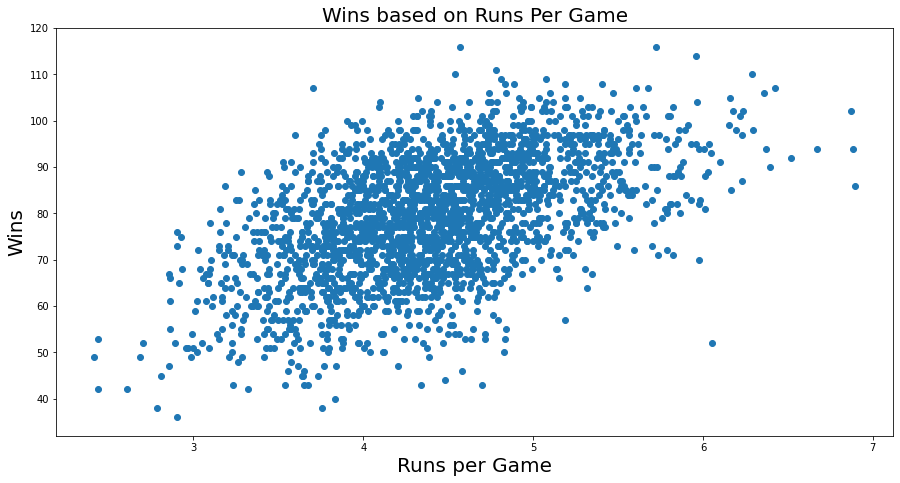

0.5331227558144798

In [12]:
plt.figure(figsize=(15, 7.5))
plt.scatter(active_teams_df['rpg'], active_teams_df['W'])
plt.title('Wins based on Runs Per Game', fontsize=20)
plt.xlabel('Runs per Game', fontsize=20)
plt.ylabel('Wins', fontsize=20)

plt.show()
plt.close

active_teams_df.corr()['W']['rpg']

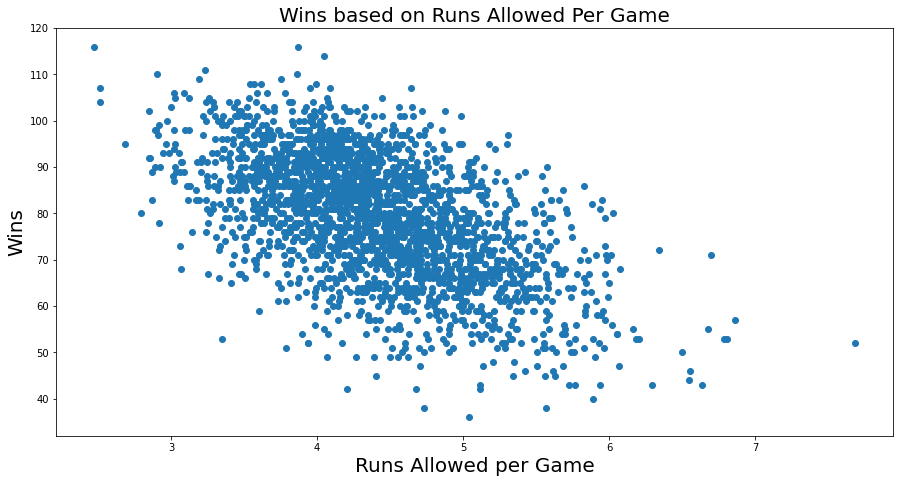

-0.5563975800290086

In [13]:
plt.figure(figsize=(15, 7.5))
plt.scatter(active_teams_df['rapg'], active_teams_df['W'])
plt.title('Wins based on Runs Allowed Per Game', fontsize=20)
plt.xlabel('Runs Allowed per Game', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.show()
plt.close

active_teams_df.corr()['W']['rapg']

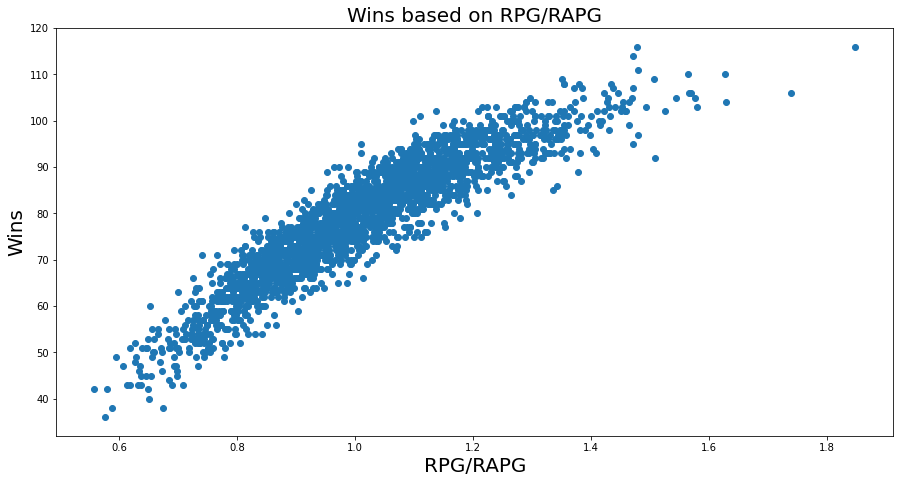

0.9225809409993341

In [14]:
plt.figure(figsize=(15, 7.5))
plt.scatter(active_teams_df['rpg/rapg'], active_teams_df['W'])
plt.title('Wins based on RPG/RAPG', fontsize=20)
plt.xlabel('RPG/RAPG', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.show()
plt.close

active_teams_df.corr()['W']['rpg/rapg']

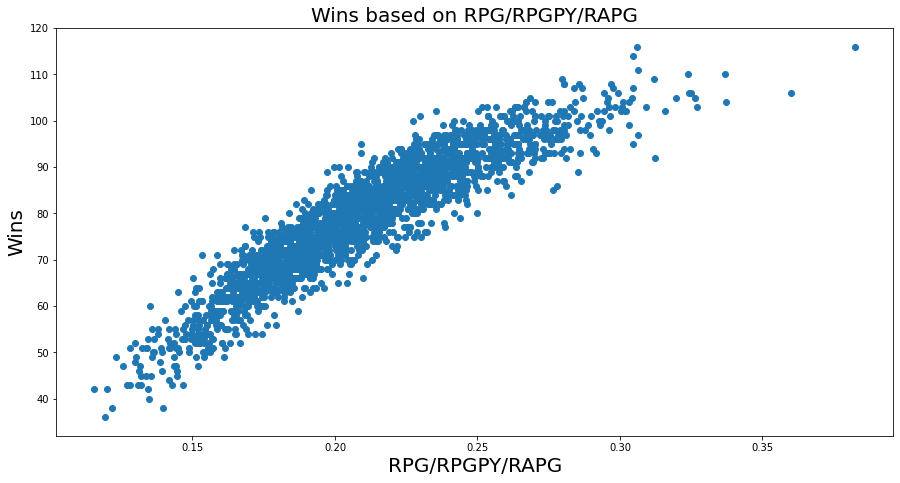

0.9225809409993365

In [15]:
plt.figure(figsize=(15, 7.5))
plt.scatter(active_teams_df['rpg/rpgpy/rapg'], active_teams_df['W'])
plt.title('Wins based on RPG/RPGPY/RAPG', fontsize=20)
plt.xlabel('RPG/RPGPY/RAPG', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.show()
plt.close

active_teams_df.corr()['W']['rpg/rpgpy/rapg']

In [16]:
data = active_teams_df.drop(columns=['yearID', 'teamID', 'SHO', 'CG'])

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['W']),
                                                    data.filter(items=['W']).pop('W'),
                                                    random_state=43)

# Linear Regression

In [17]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

LinearRegression(normalize=True)

In [18]:
lr.score(X_train, y_train)

0.9209430467130897

In [19]:
lr.score(X_test, y_test)

0.9192969031900466

In [20]:
print(mean_absolute_error(y_test, lr.predict(X_test)))

3.0251530113433103


# Ridge Regression

In [21]:
rrm = RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 1.0, 10.0), normalize=True)
rrm.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
        normalize=True)

In [22]:
rrm.score(X_train, y_train)

0.9208200186550242

In [23]:
rrm.score(X_test, y_test)

0.9197747215462204

In [24]:
# Determine mean absolute error
print(mean_absolute_error(y_test, rrm.predict(X_test)))

3.0184943580701673


# 2021 Predictions
Here, we will use 2021 projections in order to make predictions for each team for the upcoming season. Here, we will only be using runs per game / runs allowed per game to train and predict.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.filter(items=['rpg', 'rapg', 'rpg/rapg']),
                                                    data.filter(items=['W']).pop('W'),
                                                    random_state=43)

In [26]:
model = RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 1.0, 10.0), normalize=True)
model.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
        normalize=True)

In [27]:
model.score(X_train, y_train)

0.8694282601744454

In [28]:
model.score(X_test, y_test)

0.8763385456834464

In [29]:
# Determine mean absolute error
print(mean_absolute_error(y_test, model.predict(X_test)))

3.8118216924748434


## Projected Stats
Here we will use the projected stats for 2021, these statistics for runs per game and runs allowed per game are from FanGraphs.

In [30]:
def get_projections(path='./datasets/fangraphs/projections.html'):
    """Function to get projection from fangraphs"""
    
    # Get the table on the page
    with open(path) as file:
        html = file.read()
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find_all("div", "depth-charts-aspx_table")[0].find("table")
    
    # Get the header
    list_header = []
    header = table.find_all("thead")[0].find_all("tr")[1]
    
    for items in header:
        try:
            list_header.append(items.get_text())
        except Exception:
            continue
            
    # Get rows
    data = []
    rows = table.find_all("tr", "depth_team")
    
    for row in rows:
        sub_data = []
        for subrow in row:
            try:
                sub_data.append(subrow.get_text())
            except Exception:
                continue
                
        # Only want the rpg and rapg
        data.append(sub_data[0:1]+sub_data[19::])
        
    # Make a dataframe, rename columns, and make new columns
    df = pd.DataFrame(data=data, columns=list_header[0:1]+list_header[19::])
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="ignore")
        
    df.rename(columns={"RS/G": "rpg", "RA/G": "rapg"}, inplace=True)
    df['rpg/rapg'] = df['rpg'] / df['rapg']

    return df

## Make Prediction

In [31]:
# Get the projections from fangraphs
projections = get_projections()

# Make predictions
predictions_2021 = model.predict(projections.drop(columns=['Team']))
predictions_2021 = np.rint(predictions_2021)

# Get the teams
teams_2021 = projections[['Team']]

team_predictions_2021 = pd.concat([teams_2021.reset_index(drop=True),
                                   pd.Series(predictions_2021,
                                             name='Predicted Games Won')],
                                  axis=1)

# Note: these predictions are based off of the projections on 4/5/21
# The website contains the predictions based off of the prpjections before the season started, so these values here might be off a tiny bit
team_predictions_2021.sort_values(by=['Predicted Games Won'],
                                  ascending=False,
                                  ignore_index=True)

,Team,Predicted Games Won
0,Yankees,97.0
1,Mets,96.0
2,Dodgers,95.0
3,Padres,94.0
4,Astros,91.0
5,White Sox,89.0
6,Twins,87.0
7,Angels,86.0
8,Nationals,84.0
9,Blue Jays,84.0


# Just some extra testing

In [ ]:
teams_2020 = teams_df.loc[teams_df['yearID'] == 2020].copy()
teams_2020

In [ ]:
teams_2020.drop(columns=['lgID',
                         'franchID',
                         'divID',
                         'Rank',
                         'Ghome',
                         'L',
                         'DivWin',
                         'WCWin',
                         'LgWin',
                         'WSWin',
                         'SF',
                         'name',
                         'park',
                         'attendance',
                         'BPF',
                         'PPF',
                         'teamIDBR',
                         'teamIDlahman45',
                         'teamIDretro',
                         'franchID'],
                inplace=True)

teams_2020.drop(columns=['CS', 'HBP'],
                inplace=True)

teams_2020

We need a multiplier since the the 2020 season was cut short. While this isn't the best method of extrapolating the data, it should suffice for our needs. We will multiply the apporpriate stats by this ammount.

In [ ]:
multiplier = 162 / 60

for col in ['G',
            'R',
            'AB',
            'H',
            '2B',
            '3B',
            'HR',
            'BB',
            'SO',
            'SB',
            'RA',
            'SHO',
            'SV',
            'IPouts',
            'HA',
            'HRA',
            'BBA',
            'SOA',
            'E',
            'DP']:
    teams_2020[col] = teams_2020[col] * multiplier

teams_2020

Get the runs per game for the year and add some new features

In [ ]:
teams_2020['rpgpy'] = (teams_2020['R'].sum() /
                       teams_2020['G'].sum())

In [ ]:
teams_2020['rpg'] = teams_2020['R'] / teams_2020['G']
teams_2020['rapg'] = teams_2020['RA'] / teams_2020['G']
teams_2020['rpg/rapg'] = teams_2020['rpg']/teams_2020['rapg']
teams_2020['rpg/rpgpy/rapg'] = teams_2020['rpg'] / teams_2020['rpgpy'] / teams_2020['rapg']

Predict number of wins using the Ridge Regression model

In [ ]:
data_2020 = teams_2020.drop(columns=['yearID', 'teamID', 'SHO', 'CG'])
predictions_2021 = rrm.predict(data_2020.drop(columns=['W']))

In [ ]:
predictions_2021 = np.rint(predictions_2021)
teams_2021 = teams_2020[['teamID']]

team_predictions_2021 = pd.concat([teams_2021.reset_index(drop=True),
                                   pd.Series(predictions_2021,
                                             name='Predicted Games Won')],
                                  axis=1)

team_predictions_2021.sort_values(by=['Predicted Games Won'],
                                  ascending=False,
                                  ignore_index=True)